In [115]:
%config IPCompleter.greedy=True

In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob

# Importações
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('rslp')
# Stop Words em Português
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = stopwords.words('portuguese')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

import matplotlib.pyplot as plt

from wordcloud import WordCloud, ImageColorGenerator

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Mota\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mota\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# O Problema
![alt text](https://github.com/MarcosMota/AnaliseDeSentimento/blob/master/images/olist.png?raw=true)



Olist é um intermediario entre lojistas e marketplaces, ela permite o lojista gerenciar toda operação de venda de um único lugar e publicar seus produtos em grandes marketplaces, como:

- Mercado Livre
- Walmart
- Submarino
- Americanas
- Extra.com
- Casas Bahia
- Pontofrio
- Entre outros.

Com o objetivo de ajudar os lojistas melhorarem o atendimento ao cliente iremos construir uma algoritmo que nos aponte a satisfação de um cliente.


#Conjunto de Dados
Este é um conjunto de dados 
O conjunto de dados possui informações de 100 mil pedidos de 2016 a 2018 feitos em vários mercados no Brasil. Seus recursos permitem visualizar um pedido de várias dimensões: 


[Dataset Brazilian Ecommerce](https://www.kaggle.com/olistbr/brazilian-ecommerce)

- Status do pedido
- Preço
- Pagamento
- Desempenho do frete à localização do cliente
- Produto
- **Reviews escritas pelos clientes.**

## Reviews

Após que um cliente compra o produto na Olist Store, um vendedor é notificado para atender a esse pedido. Depois que o cliente recebe o produto ou a data estimada de entrega é vencida, ele recebe uma pesquisa de satisfação por e-mail, onde pode anotar a experiência da compra e anotar alguns comentários.

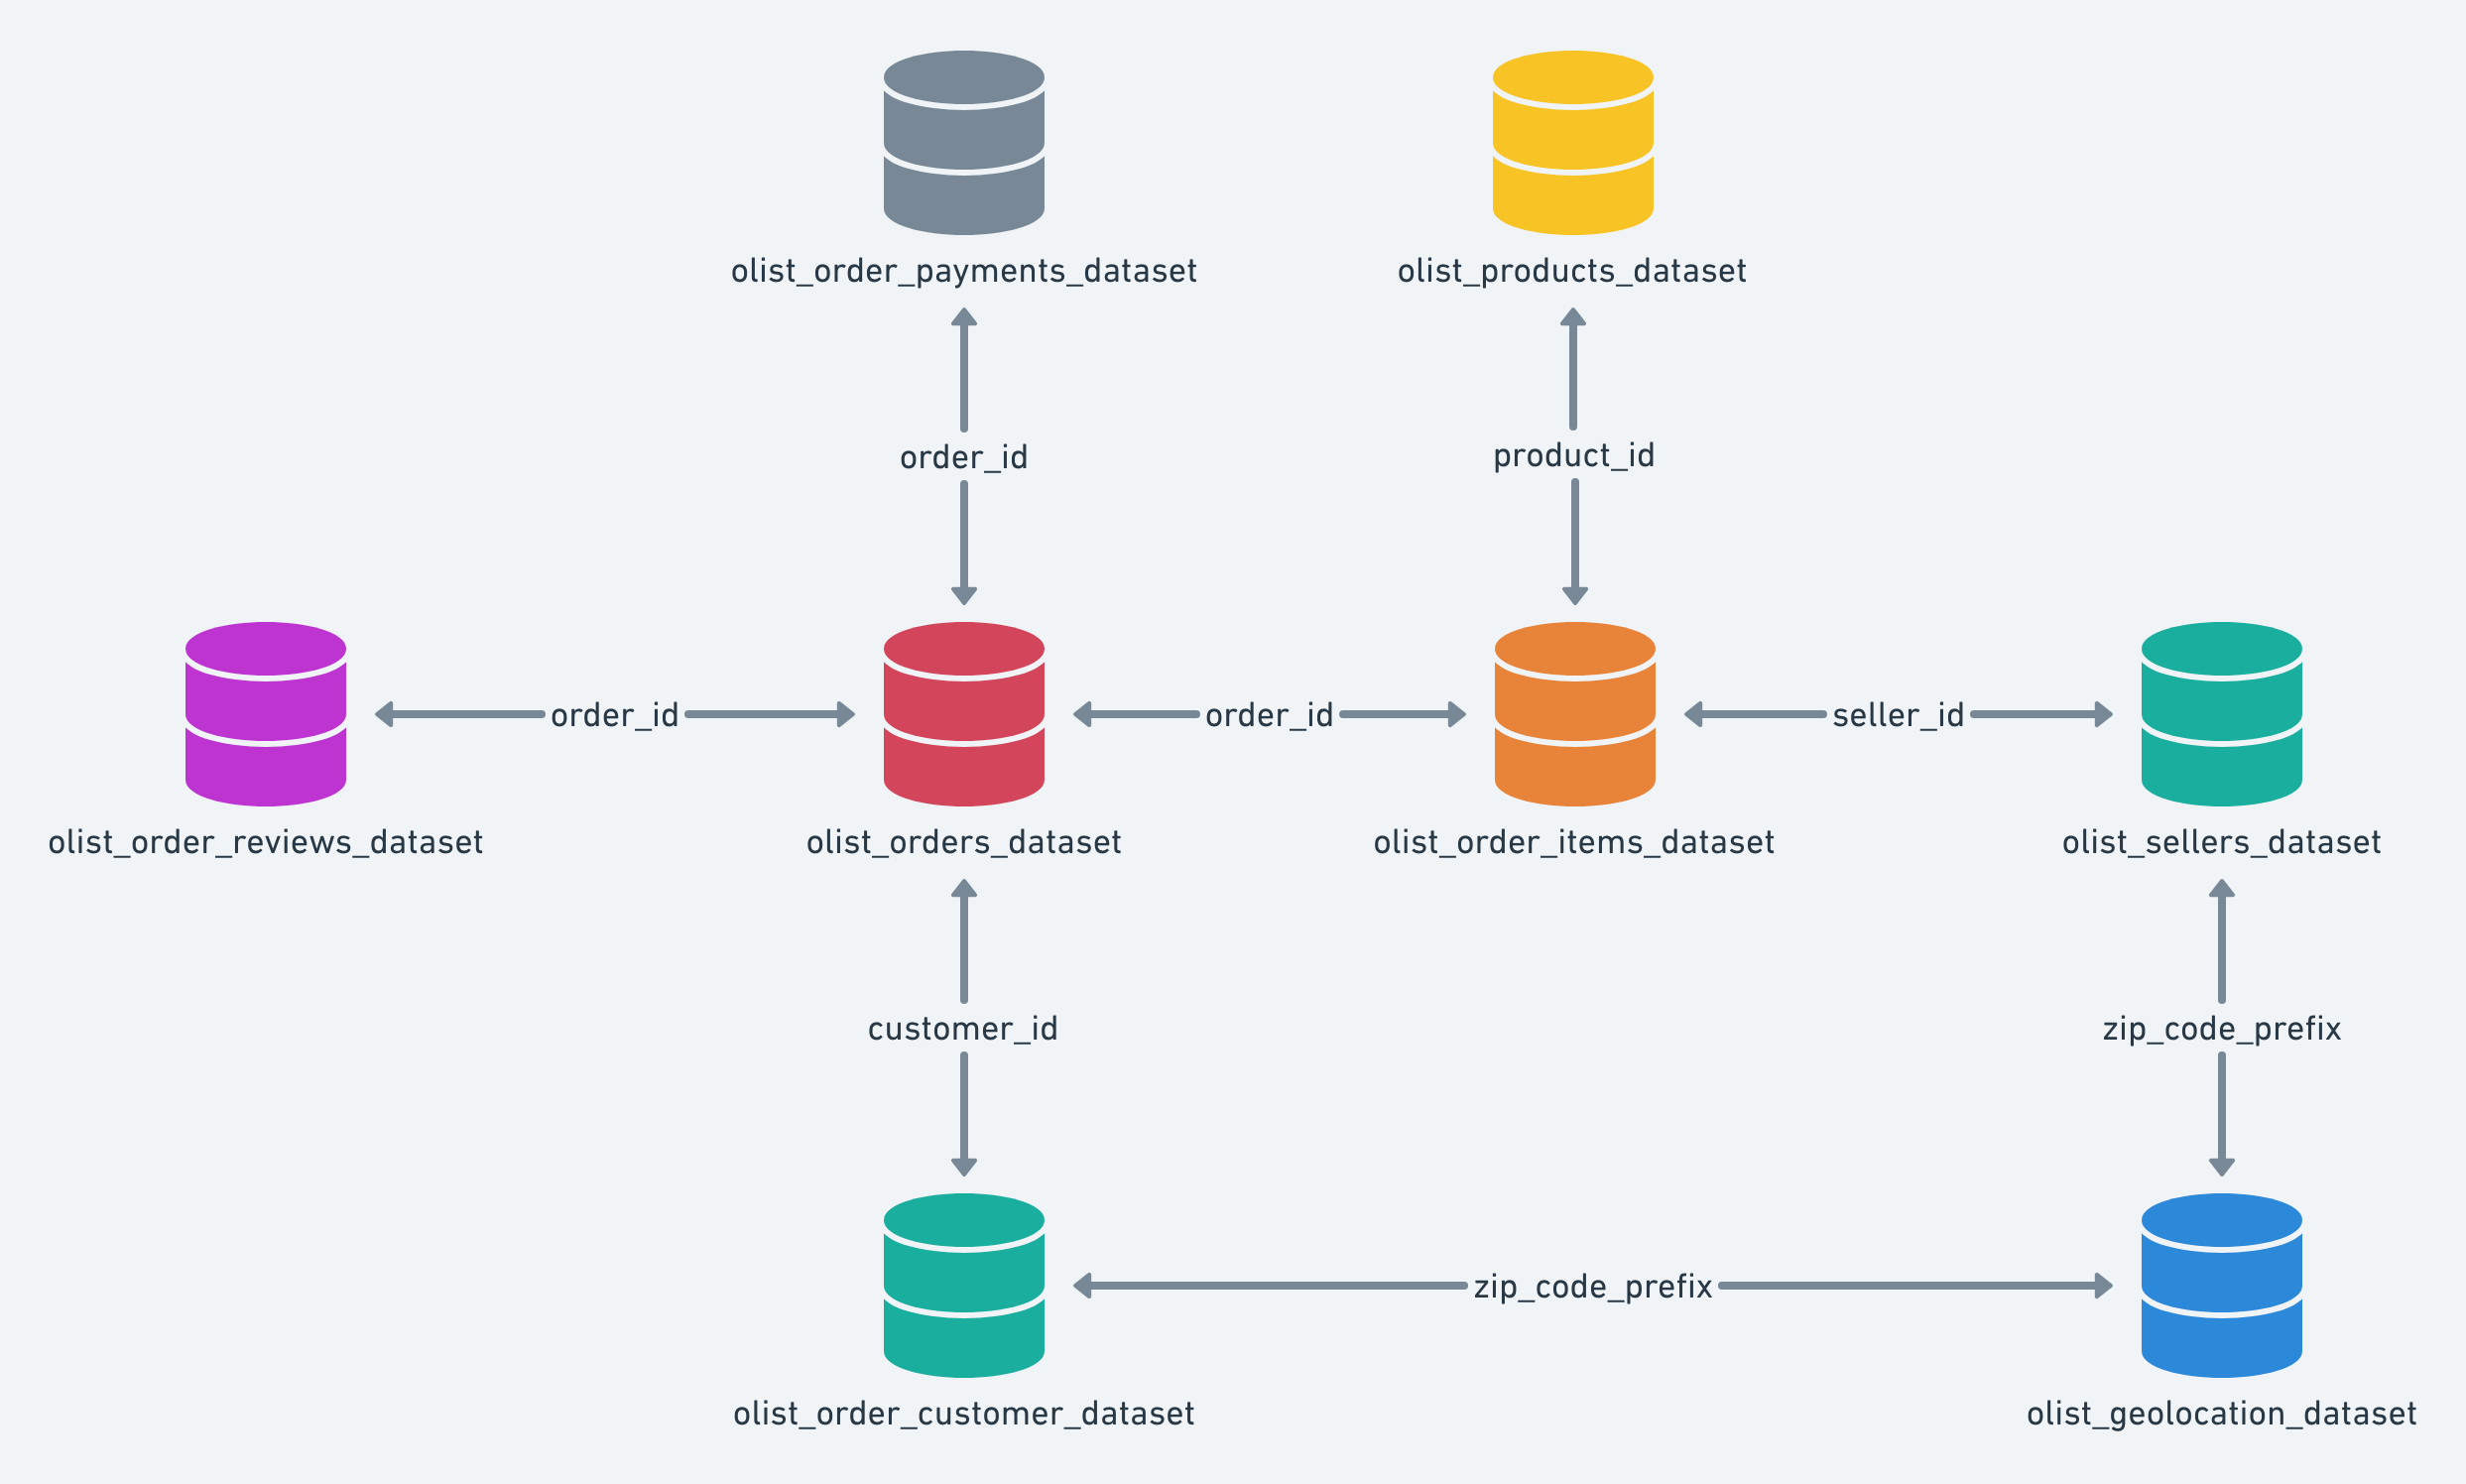

In [116]:
from functools import reduce

def load_dataset():
    ## carrega os datasets
    reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
    orders = pd.read_csv('data/olist_orders_dataset.csv')
    customers = pd.read_csv('data/olist_customers_dataset.csv')
    payments = pd.read_csv('data/olist_order_payments_dataset.csv')
    products = pd.read_csv('data/olist_products_dataset.csv')
    order_itens = pd.read_csv('data/olist_order_items_dataset.csv')
    
    ## Une os datasets
    data_frames = [reviews, orders, payments, order_itens]
    df = reduce(lambda  left,right: pd.merge(left, right, on=['order_id'], how='outer'), data_frames)
    df = pd.merge(customers, df, on=['customer_id'], how='outer')
    df = pd.merge(products, df, on=['product_id'], how='outer')
    
    ## Seleciona as colunas importantes
    columns = ['order_id', 'product_id','product_category_name', 'review_comment_message','review_score', 'order_status','customer_id', 'customer_city', 'customer_state', 'payment_type', 'payment_installments', 'payment_value']
    return df[columns]

df = load_dataset()
df.head()

,order_id,product_id,product_category_name,review_comment_message,review_score,order_status,customer_id,customer_city,customer_state,payment_type,payment_installments,payment_value
0,e17e4f88e31525f7deef66779844ddce,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,Super adooorei o delineador ele é bem preto e ...,5,delivered,f8a3e963a310aa58b60a5b1fed5bceb5,mogi-guacu,SP,debit_card,1.0,18.30
1,5236307716393b7114b53ee991f36956,3aa071139cb16b67ca9e5dea641aaa2f,artes,Excelente apontador! Em 3 segundos uma ponta p...,5,delivered,03fc97548af8f58fefc768d12b546c9c,rio de janeiro,RJ,voucher,1.0,265.99
2,01f66e58769f84129811d43eefd187fb,96bd76ec8810374ed1b65e291975717f,esporte_lazer,NaN,5,delivered,e41819d1c95c12c9ce495b630eab8aee,sao paulo,SP,credit_card,1.0,87.62
3,143d00a4f2dde4e0364ee1821577adb3,cef67bcfe19066a932b7673e239eb23d,bebes,modelo comprado: travesseiro memoria carinho B...,1,delivered,322162b5ca010c2b059cb5224dd818b1,sao paulo,SP,credit_card,2.0,121.84
4,86cafb8794cb99a9b1b77fc8e48fbbbb,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,NaN,5,delivered,c11c31965ff02cc1d7132df8edfcbc22,sao paulo,SP,credit_card,4.0,46.19


In [117]:
df.drop_duplicates()

,order_id,product_id,product_category_name,review_comment_message,review_score,order_status,customer_id,customer_city,customer_state,payment_type,payment_installments,payment_value
0,e17e4f88e31525f7deef66779844ddce,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,Super adooorei o delineador ele é bem preto e ...,5,delivered,f8a3e963a310aa58b60a5b1fed5bceb5,mogi-guacu,SP,debit_card,1.0,18.30
1,5236307716393b7114b53ee991f36956,3aa071139cb16b67ca9e5dea641aaa2f,artes,Excelente apontador! Em 3 segundos uma ponta p...,5,delivered,03fc97548af8f58fefc768d12b546c9c,rio de janeiro,RJ,voucher,1.0,265.99
2,01f66e58769f84129811d43eefd187fb,96bd76ec8810374ed1b65e291975717f,esporte_lazer,NaN,5,delivered,e41819d1c95c12c9ce495b630eab8aee,sao paulo,SP,credit_card,1.0,87.62
3,143d00a4f2dde4e0364ee1821577adb3,cef67bcfe19066a932b7673e239eb23d,bebes,modelo comprado: travesseiro memoria carinho B...,1,delivered,322162b5ca010c2b059cb5224dd818b1,sao paulo,SP,credit_card,2.0,121.84
4,86cafb8794cb99a9b1b77fc8e48fbbbb,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,NaN,5,delivered,c11c31965ff02cc1d7132df8edfcbc22,sao paulo,SP,credit_card,4.0,46.19
...,...,...,...,...,...,...,...,...,...,...,...,...
119146,2f634e2cebf8c0283e7ef0989f77d217,NaN,NaN,"Comprei um perfume Bleu de Chanel , paguei e n...",1,unavailable,7353b0fb8e8d9675e3a704c60ca44ebe,sao paulo,SP,credit_card,12.0,615.53
119147,2b0edc4c59d83dcef85466718c36a317,NaN,NaN,NaN,2,unavailable,5effe9491d0f5a1c12ee4a384ec09bdf,suzano,SP,credit_card,1.0,112.91
119148,81b7c7bbc8ec003eeb67d87441a6a148,NaN,NaN,NaN,3,canceled,75c6e03e7206bd1dd59f427c9f75142a,campinas,SP,voucher,1.0,92.76
119149,8b08f0e729f58529ed03e763270f78d5,NaN,NaN,"O produto estava anunciado no site, mas não ti...",1,unavailable,1761db2f0d235bbfa1c281093198af0c,rio de janeiro,RJ,credit_card,1.0,136.50


### Remove nulos e duplicados

In [119]:
## Remove todos os textos que são nulos

print(f'Quantidade de observações antes: {df.shape[0]}\n')
df = df.dropna(subset=['review_comment_message'])
print(f'Quantidade de observações depois: {df.shape[0]}\n')

Quantidade de observações antes: 51250

Quantidade de observações depois: 51250



In [120]:
## Remove todos os textos que são duplicados
print(f'Quantidade de observações antes: {df.shape[0]}\n')
df = df.drop_duplicates()
print(f'Quantidade de observações depois: {df.shape[0]}\n')

Quantidade de observações antes: 51250

Quantidade de observações depois: 45586



In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class LimpezaPipe(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        texto_transformado = []
        for texto in X:
          # Remover quebras de linha
          texto = re.sub('\n', ' ', texto)

          # Remover carriage return
          texto = re.sub('\r', ' ', texto)

          # Substituir numero pela palavra 'número'  
          texto = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', ' numero ', texto)

          # Remover os alfas núméricos
          texto = re.sub(r'R\$', ' ', texto)
          texto = re.sub(r'\W', ' ', texto)
          texto = re.sub(r'\s+', ' ', texto)

          # Remover os hyperlinks
          urls = re.findall('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', texto)
          if len(urls) == 0:
              pass
          else:
              for url in urls:
                  for link in url:
                      texto = texto.replace(link, '')
              texto = texto.replace(':', '')
              texto = texto.replace('/', '')
          
          texto_transformado.append(texto)
        return texto_transformado

In [121]:
limpezaPipe = LimpezaPipe()
df['comment_clear'] = limpezaPipe.transform(df['review_comment_message'])

In [122]:
from googletrans import Translator
# obtem score pelo ranking
score = [0, 2, 3, 5]
polarity = [-1, 0, 1]
df['polarity_rank'] = pd.cut(df['review_score'], bins=score, labels=polarity)

# obtem score pelas regras
df['polarity_rule'] = df['comment_clear'].map(lambda text: TextBlob(text).sentiment.polarity)
df['subjectivity'] = df['comment_clear'].map(lambda text: TextBlob(text).sentiment.subjectivity)

df['review_len'] = df['comment_clear'].astype(str).apply(len)
df['word_count'] = df['comment_clear'].apply(lambda x: len(str(x).split()))

In [123]:
df.head()

,order_id,product_id,product_category_name,review_comment_message,review_score,order_status,customer_id,customer_city,customer_state,payment_type,payment_installments,payment_value,comment_clear,polarity_rank,polarity_rule,subjectivity,review_len,word_count
0,e17e4f88e31525f7deef66779844ddce,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,Super adooorei o delineador ele é bem preto e ...,5,delivered,f8a3e963a310aa58b60a5b1fed5bceb5,mogi-guacu,SP,debit_card,1.0,18.30,Super adooorei o delineador ele é bem preto e ...,1,0.333333,0.666667,196,44
1,5236307716393b7114b53ee991f36956,3aa071139cb16b67ca9e5dea641aaa2f,artes,Excelente apontador! Em 3 segundos uma ponta p...,5,delivered,03fc97548af8f58fefc768d12b546c9c,rio de janeiro,RJ,voucher,1.0,265.99,Excelente apontador Em numero segundos uma pon...,1,0.000000,0.000000,58,8
3,143d00a4f2dde4e0364ee1821577adb3,cef67bcfe19066a932b7673e239eb23d,bebes,modelo comprado: travesseiro memoria carinho B...,1,delivered,322162b5ca010c2b059cb5224dd818b1,sao paulo,SP,credit_card,2.0,121.84,modelo comprado travesseiro memoria carinho BA...,-1,0.000000,0.000000,170,24
7,9632facd8bd95315d63a23bf616d85b0,732bd381ad09e530fe0a5f457d81becb,cool_stuff,Veio faltando o bebê conforto,2,delivered,7e395b4bf53aea8c56b1213f1b801411,guarulhos,SP,credit_card,5.0,985.76,Veio faltando o bebê conforto,-1,0.000000,0.000000,30,5
8,6ecf7023e8dd4ec8b08746c35b9fcb60,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,Na entrega veio faltando os dois assento futon...,2,delivered,181e2217f874cb5390be37f378db5e07,ribeirao pires,SP,credit_card,3.0,163.88,Na entrega veio faltando os dois assento futon...,-1,0.000000,0.000000,143,26


## Analise Exploratória

### Os 5 comentários com maior polaridade

In [124]:
print("----Por regras----\n")
cl1 = df.loc[df.polarity_rule == 1, ['review_comment_message']].sample(5, replace=True).values
for c in cl1:
    print(c[0])
print("\n\n----Por ranking----\n")
cl2 = df.loc[df.polarity_rank == 1, ['review_comment_message']].sample(5, replace=True).values
for c in cl2:
    print(c[0])

----Por regras----

Fiz um pedido só, e veio separado.as.entregas faltando um produto (best whey)
perfect...amei
Fiz um pedido só, e veio separado.as.entregas faltando um produto (best whey)
perfect...amei
Pedi 5 best Whey e recebi apenas 3!
Gostaria de saber como faço para receber os que faltaram?


----Por ranking----

Produto superou minha expectativa. Conserva de maneira perfeita. Ótimo acabamento. 
Entrega foi bem antes do Plazo,e o produto foi o e que eu pedi
Exatamente como na foto e de otima qualidade... chegou antes do prazo... recomendo...
Muito Boa.
Recomendo!!!


### Os 5 comentários com menor polaridade

In [125]:
print("----Por regras----\n")
cl1 = df.loc[df.polarity_rule > 0, ['review_comment_message']].sample(5, replace=True).values
for c in cl1:
    print(c[0])
print("\n\n----Por ranking----\n")
cl2 = df.loc[df.polarity_rank == -1, ['review_comment_message']].sample(5, replace=True).values
for c in cl2:
    print(c[0])

----Por regras----

produto chegou em bom estado, e a qualidade bem superior a algumas que jah comprei , percebece que e bem mais resistente
super recomendo chegou direitinho
O produto é igual ao descrito no site, entrega rápida, super confiável.
Cortina, ok
Tecido muito fino, fica muito n transparência.
Ótima entrega.produto bem embalado.prazos cumpridos.tudo ok


----Por ranking----

Simplesmente horrível o produto 
não recebi ainda, e nem fui avisada que atrasaria
Não recebi o produto. Então não tem como avaliar. 
Comprei uma mesa com 2 compartimentos, um para o notebook e outro para o mouse e encaminharam uma mesa mais simples com apenas um compartimento, estou aguardando o retorno para encaminharem o produto 
Recebi o produto porém não é original,e como é um produto pra ingerir não quero colocar a minha saúde em risco. 


### Os 5 comentários com polaridade neutra

In [126]:
print("----Por regras----\n")
cl1 = df.loc[df.polarity_rule == 0, ['review_comment_message']].sample(5, replace=True).values
for c in cl1:
    print(c[0])
print("\n\n----Por ranking----\n")
cl2 = df.loc[df.polarity_rank == 0, ['review_comment_message']].sample(5, replace=True).values
for c in cl2:
    print(c[0])

----Por regras----

Bom produto!
Comprei o produto,a entrega dentro do esperado,o produto em perfeito estado!!
Eu recomendo!!!!
Muito bom pode confiar!!

Recomendo
muito bonito.
Chegou muito antes do prazo estimado


----Por ranking----

Dei 3 estrelas pois achei a alça um pouco frágil para o tamanho da maleta.
A demora para entrega e rastreamento do produto foi muito dificultosa
Os detalhes do produto e o acompanhamento da entrega deixam a desejar !
Não há como avaliar o produto pois o mesmo ainda não foi entregue em minha residência.gostaria de saber o porquê do atraso é onde está meu produto agora.
Top


In [14]:
import chart_studio.plotly as py
import cufflinks as cf
import warnings 
warnings.filterwarnings('ignore')
import plotly.graph_objs as go
import seaborn as sns


### A distribuição da polaridade

<AxesSubplot:xlabel='polarity_rule', ylabel='Density'>

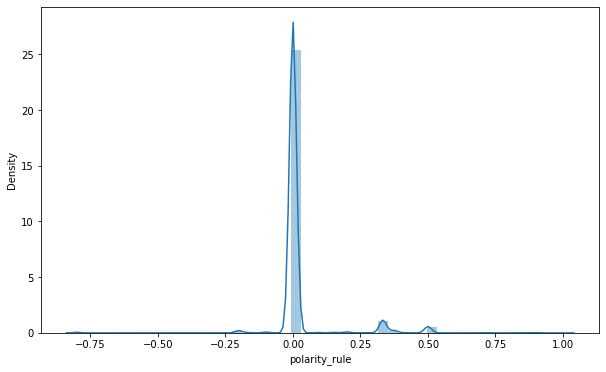

In [127]:
sns.distplot(df['polarity_rule'])

### A distribuição das estrelas

<AxesSubplot:xlabel='review_score', ylabel='Density'>

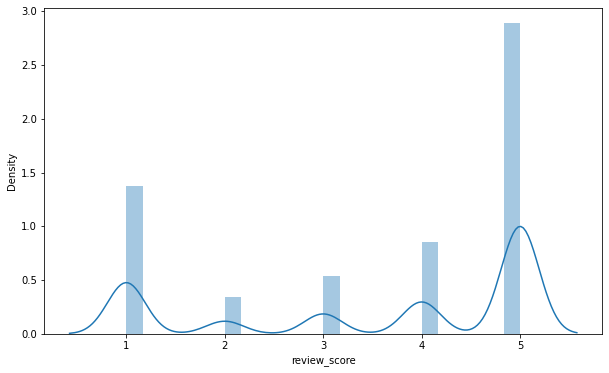

In [128]:
sns.distplot(df['review_score'])

<AxesSubplot:xlabel='review_len', ylabel='Density'>

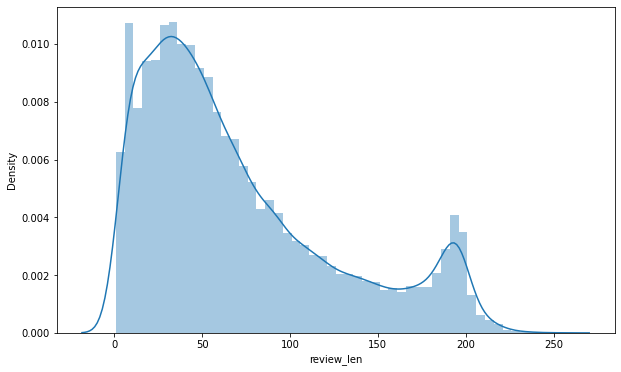

In [129]:
sns.distplot(df['review_len'])

In [140]:
def get_rank_word(data, top=10, method="C"):
    # TfidfVectorizer CountVectorizer
    if(method is "C"):
        co = CountVectorizer(stop_words=STOPWORDS)
        counts = co.fit_transform(data)
        return pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(top)
    else:
        co = TfidfVectorizer(stop_words=STOPWORDS)
        counts = co.fit_transform(data)
        return pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(top)

### As palavras mais frequentes

In [142]:
get_rank_word(df['review_comment_message'], top=20, method="C")


,0
produto,20186
prazo,9030
entrega,7194
recebi,6412
chegou,6168
antes,5934
bom,4918
recomendo,4644
entregue,4449
veio,3794


### As palavras mais frequentes com polaridade positiva

In [146]:
get_rank_word(df[(df.polarity_rank == 1)]['review_comment_message'], top=20, method="T")

,0
produto,2213.859634
bom,2012.016397
prazo,1739.793844
recomendo,1464.690906
antes,1418.281382
entrega,1313.622118
chegou,1172.213119
ótimo,924.740632
excelente,882.399700
entregue,794.942006


### As palavras mais frequentes com polaridade negativa

In [147]:
get_rank_word(df[(df.polarity_rank == -1)]['review_comment_message'], top=20, method="C")

,0
produto,7012
recebi,4095
comprei,2311
veio,1881
entregue,1760
entrega,1655
ainda,1632
chegou,1469
nao,1115
pedido,1111


In [148]:
def plot_rank(value, rankBy=5, asc=False):
    d = df.groupby(value).count()['order_id'].reset_index(name="count")
    d['rank'] = d['count'].rank()
    d= d.sort_values('rank', ascending=asc)[:rankBy]
    sns.barplot(x=value, y="count", data=d)



## Estados que mais compram

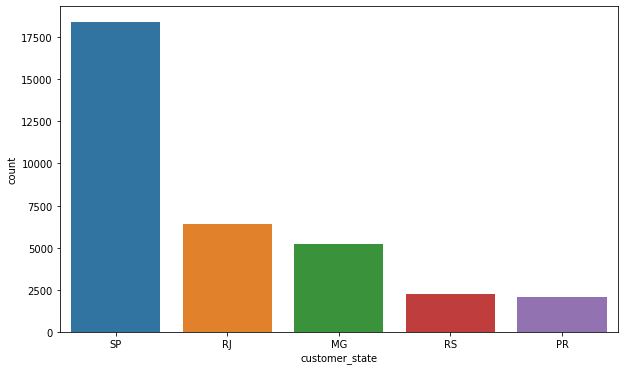

In [149]:
plot_rank('customer_state')

## Estados que menos compram

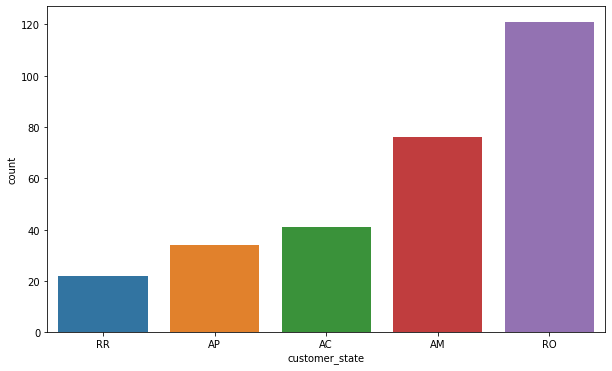

In [150]:
plot_rank('customer_state', asc=True)

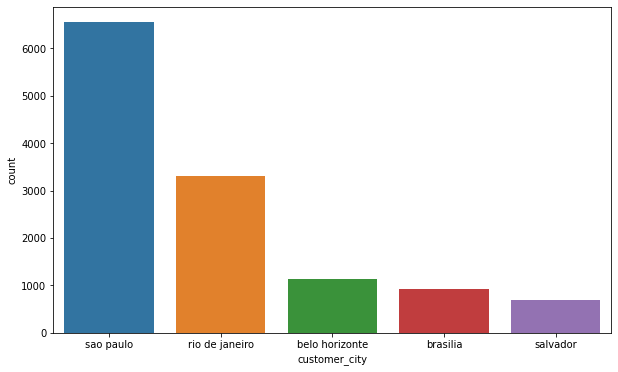

In [151]:
d = df.groupby('customer_city').count()['order_id'].reset_index(name="count")
d['rank'] = d['count'].rank()
d= d.sort_values('rank', ascending=False)[:5]
sns.barplot(x="customer_city", y="count", data=d);

In [95]:
def plotWordCloud(text):
  text = " ".join(s for s in text)
  # cria um wordcloud
  wordcloud = WordCloud(stopwords=STOPWORDS,
                        width=1600, height=800).generate(text)

  # plota o wordcloud
  fig, ax = plt.subplots(figsize=(10,6))
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.set_axis_off()

### O que as pessoas estão dizendo?



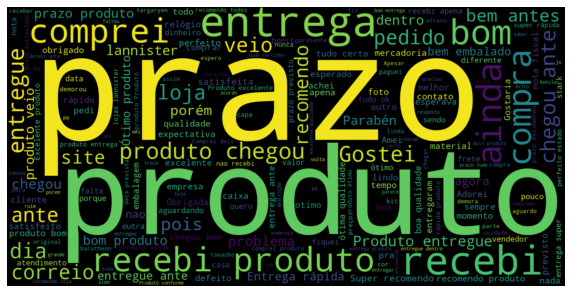

In [96]:
text = df['review_comment_message']
plotWordCloud(text)

### O que as pessoas estão dizendo quando estão satisfeitas?

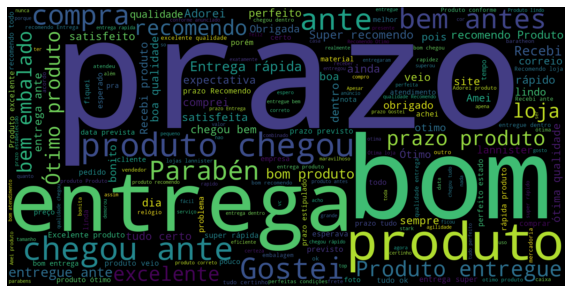

In [30]:
text = df[df.polarity == 1]['review_comment_message']
plotWordCloud(text)

### O que as pessoas estão dizendo quando estão insatisfeitas?

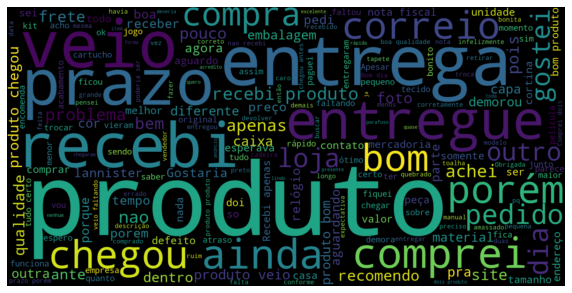

In [29]:
text = df[df.polarity == 0]['review_comment_message']
plotWordCloud(text)

#Pre Processamento
A etapa de pré processamento gasta 80% do tempo total gasto na maioria dos projetos de ciência de dados é gasto na limpeza e pré-processamento dos dados. Dessa forma, vamos construir nossa solução de modo que possibilite automatizar e reutilizar as etapas criadas nesse projeto.



In [152]:
df = df.rename(columns={"polarity_rank": "polarity"})


## Selecionar Features




In [153]:
colunas = ['review_comment_message','polarity']
data = df[colunas]
data.head()

,review_comment_message,polarity
0,Super adooorei o delineador ele é bem preto e ...,1
1,Excelente apontador! Em 3 segundos uma ponta p...,1
3,modelo comprado: travesseiro memoria carinho B...,-1
7,Veio faltando o bebê conforto,-1
8,Na entrega veio faltando os dois assento futon...,-1


## Pipeline
Iremos utilizar os Pipelines do Scikit-Learn, que são compostos por etapas baseadas em heranças, das quais cada etapa poderá ser um transformador. 

In [101]:
# Importações
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('rslp')
# Stop Words em Português
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = stopwords.words('portuguese')


[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Mota\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mota\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [155]:
texto = ['O produto chegou\n Porem ele está quebrado, quero os meus R$12 de volta. \n\r']

### Limpeza do Texto


In [154]:
class LimpezaPipe(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        texto_transformado = []
        for texto in X:
          # Remover quebras de linha
          texto = re.sub('\n', ' ', texto)

          # Remover carriage return
          texto = re.sub('\r', ' ', texto)

          # Substituir numero pela palavra 'número'  
          texto = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', ' numero ', texto)

          # Remover os alfas núméricos
          texto = re.sub(r'R\$', ' ', texto)
          texto = re.sub(r'\W', ' ', texto)
          texto = re.sub(r'\s+', ' ', texto)

          # Remover os hyperlinks
          urls = re.findall('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', texto)
          if len(urls) == 0:
              pass
          else:
              for url in urls:
                  for link in url:
                      texto = texto.replace(link, '')
              texto = texto.replace(':', '')
              texto = texto.replace('/', '')
          
          texto_transformado.append(texto)
        return texto_transformado

In [156]:
limpezaPipe = LimpezaPipe()
texto = limpezaPipe.transform(texto)
texto

['O produto chegou Porem ele está quebrado quero os meus numero de volta ']

### Stop Words



In [157]:
import string
class StopWordsPipe(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def _removeStopPipe(self, text):
      nopunc = [char for char in text if char not in string.punctuation]
      nopunc = ''.join(nopunc)
      return [word for word in nopunc.split() if word.lower() not in STOPWORDS]

    def transform(self, X, y=None):
      texto_transformado = list(map(lambda c: self._removeStopPipe(c), X))
      texto_transformado = list(map(lambda x: ' '.join(x), texto_transformado))
      return texto_transformado

In [158]:
stopwordsPipe = StopWordsPipe()
texto = stopwordsPipe.transform(texto)
texto

['produto chegou Porem quebrado quero numero volta']

### Stemming

É a técnica que reduz um termo ao seu radical, removendo afixos e vogais temáticas. Um do seus objetivos é reduzir a quantidade de palavras na base de dados. A redução de vocabulário permite maior velocidade de processamento e menor número de erros causados por combinações não previstas.

Exemplos:

*   **Frequentemente** se torna “Frequent”
*   **Copiar** se torna “Copi”


In [159]:
class SteammingPipe(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def _applySteaming(self, c):
        stemmer = RSLPStemmer()
        return list(map(lambda x: stemmer.stem(x), [word for word in c.split()]))
    
    def transform(self, X, y=None):
        texto_transformado = list(map(lambda c: self._applySteaming(c), X))
        texto_transformado = list(map(lambda x: ' '.join(x), texto_transformado))
        return texto_transformado

In [160]:
steammingPipe = SteammingPipe()
texto = steammingPipe.transform(texto)
texto

['produt cheg por quebr quer numer volt']

### Construção do Pipeline

In [161]:
pipe_preprocessamento = Pipeline([
    ('limpeza', LimpezaPipe()),
    ('stopwords', StopWordsPipe()),
    ('stemming', SteammingPipe()),
])

In [162]:

review_comment_message = data['review_comment_message']
review_preprocessados = pipe_preprocessamento.fit_transform(review_comment_message)

In [163]:

vectorizer = CountVectorizer(max_features=300, stop_words=stopwords.words('portuguese'))
X = vectorizer.fit_transform(review_preprocessados).toarray()


In [164]:
X

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Treinamento

In [165]:
def mostrarPolaridade(pred):
    if pred[0] == 1:
        return 'Positivo'
    elif pred[0] == 0:
        return 'Negativo'

## Separar dados de treinamento

In [166]:
from sklearn.model_selection import train_test_split

y = df['polarity'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)


## Regressão Logistica


In [168]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression

# Treinamento
modelo = LogisticRegression( max_iter=1000,  dual=False)
modelo.fit(X_train, y_train,)

LogisticRegression(max_iter=1000)

In [170]:
# Validação
acc = cross_val_score(modelo, X_test, y_test, cv=5, scoring='accuracy')
acc.mean()


0.813030271443386

In [50]:
acc

array([0.81103801, 0.81499086, 0.81462523, 0.80840951, 0.81608775])

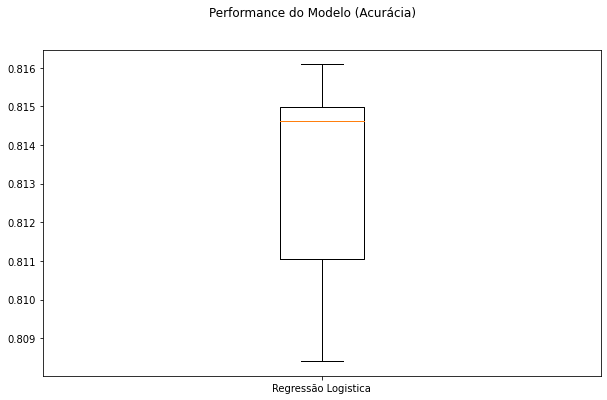

In [51]:
fig = plt.figure()
fig.suptitle('Performance do Modelo (Acurácia)')
ax = fig.add_subplot(111)
ax.set_xticklabels(['Regressão Logistica'])
plt.boxplot(acc)
plt.show()

## Validação

In [171]:
frase = ['Que produto bom!!']
frase_preprocessada = pipe_preprocessamento.fit_transform(frase)

frase_transformada = vectorizer.transform(frase_preprocessada).toarray()
#
pred = modelo.predict(frase_transformada)
pred[0]

1

In [174]:
frase = ['Produto é mais ou menos, mais demorou para chegar!!']
frase_preprocessada = pipe_preprocessamento.fit_transform(frase)

# Vectorizing
frase_transformada = vectorizer.transform(frase_preprocessada).toarray()
pred = modelo.predict(frase_transformada)
pred[0]

-1